### Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split

train = pd.read_csv("train_values.csv")
y_labels = pd.read_csv("train_labels.csv")
train['accepted'] = y_labels['accepted']

### Handle Missing Values

In [2]:
train.fillna(train.median(), inplace=True)
train.describe()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,249999.500000,1.366276,1.047650,2.066810,1.109590,221.753158,2.764722,181.606972,23.726924,144.542062,...,1.462374,100.121312,5396.982356,31.225669,69158.876302,92.200385,1423.172866,1880.147458,3720.121344,0.500228
std,144337.711634,0.690555,0.231404,0.948371,0.326092,590.641648,0.543061,138.464169,15.982768,100.243612,...,0.677685,147.474440,2667.723303,25.798784,14478.232811,13.990187,721.027517,893.717989,1838.313175,0.500000
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,14.000000,0.534000,17858.000000,3.981000,4.000000,1.000000,0.000000,0.000000
25%,124999.750000,1.000000,1.000000,1.000000,1.000000,93.000000,3.000000,25.000000,6.000000,57.000000,...,1.000000,49.000000,3805.000000,11.191000,60071.000000,89.145000,963.000000,1323.000000,2442.000000,0.000000
50%,249999.500000,1.000000,1.000000,2.000000,1.000000,162.000000,3.000000,192.000000,26.000000,131.000000,...,1.000000,74.000000,4975.000000,22.901000,67526.000000,100.000000,1327.000000,1753.000000,3731.000000,1.000000
75%,374999.250000,2.000000,1.000000,3.000000,1.000000,266.000000,3.000000,314.000000,37.000000,246.000000,...,2.000000,112.000000,6379.000000,44.486000,74714.250000,100.000000,1754.000000,2275.000000,5436.000000,1.000000
max,499999.000000,4.000000,3.000000,3.000000,3.000000,100878.000000,3.000000,408.000000,52.000000,324.000000,...,4.000000,10139.000000,37097.000000,100.000000,125248.000000,100.000000,8771.000000,13623.000000,6508.000000,1.000000


### Feature Engineering

In [3]:
# add loan_income_ratio
train['loan_income_ratio'] = train['loan_amount'] / train['applicant_income']

In [4]:
train.head(1)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted,loan_income_ratio
0,0,3,1,1,1,70.0,3,18,37,246,...,6203.0,44.23,60588.0,50.933,716.0,2642.0,4536,False,1,2.916667


### Encoding

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
train['co_applicant'] = le.fit_transform(train['co_applicant'])
train.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted,loan_income_ratio
0,0,3,1,1,1,70.0,3,18,37,246,...,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,0,1,2.916667
1,1,1,1,3,1,178.0,3,369,52,299,...,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,0,0,3.122807
2,2,2,1,3,1,163.0,3,16,10,306,...,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,0,1,2.432836
3,3,1,1,1,1,155.0,1,305,47,180,...,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,1,1,1.476190
4,4,1,1,1,1,305.0,3,24,37,20,...,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,0,1,4.295775


### Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

# target
#y = train.pop('accepted')

# target with dropped values
y = train.pop('accepted').drop(columns=['row_id', 'occupancy', 'loan_type', 'applicant_sex', 'number_of_1_to_4_family_units', 
                                        'population', 'tract_to_msa_md_income_pct', 'applicant_ethnicity', 'number_of_owner-occupied_units',
                                        'co_applicant', 'msa_md', 'state_code', 'ffiecmedian_family_income'])

features = train

# features
X = features.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [8]:
X_train.shape, X_test.shape

((400000, 23), (100000, 23))

### Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

# fit the scaler based upon the training set
scaler = StandardScaler().fit(X_train)

# scale the train features array 
X_train = scaler.transform(X_train)

# scale the test features array (based on the training fit)
X_test = scaler.transform(X_test)

In [10]:
print(X_train[0])

[ 1.37210005 -0.53006789 -0.20639017 -1.12519645  2.73471192  0.16107647
  0.43341641  1.01368462  0.8294377  -0.44415196 -0.07037885 -2.71784098
 -0.68216568  1.2777048   0.26533192  1.61965151  2.42381895 -1.32017066
 -0.87834999 -0.35754723  1.37043465  1.2245599  -0.18104255]


### XGBoost

In [11]:
# build and fit xgb
xgb = xgboost.XGBClassifier(objective = 'binary:hinge', eval_metric='error', min_child_weight = 6, max_depth = 10, min_samples_split = 2, min_samples_leaf=50, n_estimators = 500, random_state = 50, n_jobs=-1)
xgb = xgb.fit(X_train, y_train)

# print the xgb score 
print(xgb.score(X_train, y_train))

0.7585575


C:\Users\L.Spencer\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [14]:
# apply the model to the test set and output score
xgb.score(X_test, y_test)

C:\Users\L.Spencer\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.70667

In [15]:
# xgb feature importances
xgb_feature_importances = xgb.feature_importances_

Feature importances out of 23 total features


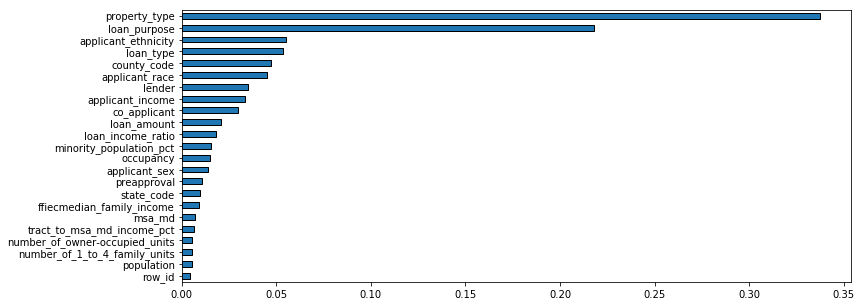

In [16]:
feature_importances = pd.Series(xgb_feature_importances, index = features.columns)
n_features = (feature_importances>0).sum()
feature_importances.sort_values().tail(30).plot(kind="barh", edgecolor="black", color="#1F77B4", figsize=(12,5));
print("Feature importances out of " + str(n_features) + " total features")

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# build and fit the random forest classifer (rfc)
rfc = RandomForestClassifier(max_depth = 20, min_samples_split = 2, min_samples_leaf=50, n_estimators = 500, random_state = 50, n_jobs=-1)
forest = rfc.fit(X_train, y_train)

# print the score of the fitted random forest classifier
print(forest.score(X_train, y_train))

In [ ]:
# apply the model to the test set and output score
forest.score(X_test, y_test)

In [ ]:
# random forest feature importances
rfr_feature_importances = forest.feature_importances_

In [ ]:
feature_importances = pd.Series(rfr_feature_importances, index = features.columns)
n_features = (feature_importances>0).sum()
feature_importances.sort_values().tail(30).plot(kind="barh", edgecolor="black", color="#1F77B4", figsize=(12,5));
print("Feature importances out of " + str(n_features) + " total features")

### Cross Validation

In [ ]:
# pass all the data to cross validation, as k-folds will split the data
from sklearn.model_selection import cross_val_score
cv = cross_val_score(xgb, X, y, cv=5)
print(cv)
print("Accuracy: " + str(round(cv.mean() * 100,2)) + "%")
print("Variance: " + str(round(cv.std() * 100,2)) + "% (+/-)")

### Prepare Test Dataset

In [ ]:
test = pd.read_csv("test_values.csv")

In [ ]:
# fill missing values
test.fillna(train.median(), inplace=True)
test.describe()

In [ ]:
# add loan_income_ratio
test['loan_income_ratio'] = test['loan_amount'] / test['applicant_income']

In [ ]:
# encode co-applicant
le = LabelEncoder()
test['co_applicant'] = le.fit_transform(test['co_applicant'])

In [ ]:
# extract test features
test_features = test.drop(columns=['row_id', 'occupancy', 'loan_type', 'applicant_sex', 'number_of_1_to_4_family_units', 'population', 'tract_to_msa_md_income_pct',
                              'applicant_ethnicity', 'number_of_owner-occupied_units', 'co_applicant', 'msa_md'])

In [ ]:
# scale test data

# fit the scaler based upon the training set
scaler = StandardScaler().fit(features)

# scale the train features array 
test_features = scaler.transform(test_features)

### Prediction

In [ ]:
# predicting on the "test" dataset, where sale price is unknown
predict = xgb.predict(test_features)

print(predict)

In [ ]:
output = pd.DataFrame()
output['row_id'] = y_labels['row_id']
output['accepted'] = predict

In [ ]:
#output.to_csv("submission1.csv", index=False)